# clasificación usando transnfer learning sobre redes convolucionales.
## Implementación en Pytorch.

**Javier Arturo Rozo**

**Juan Diego Estrada**

**Mauricio Cuscagua**

Universidad Eafit

2020

En este Notebook se preprocesan las imagenes para ser usadas en una red convolucional con los parametros de imagenet, se realiza trasnfer learning sobre algunos modelos y se evaluan los resultados.

## Dataset: Graffitis de artistas

El dataset se creó por el equipo como parte de este proyecto, son 5 clases con obras de 5 artistas dde graffiti. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

#sklearn for metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from itertools import cycle


from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import seaborn as sn




### indentificación de gpu y numero de unidades.



In [2]:
# Location of data
datadir = '/Users/Javier/Archivos/MIDS/Semestre III/trabajo de grado/pytorch_challenge-master/pytorch_challenge-master/artgraffv4/'
traindir = datadir + 'train'
validdir = datadir + 'val/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 32

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


## Data Exploration

Los datos estan almacenados en una estructura que separó previamente train, validation y test.

```
/datadir
    /train
            /class_1
            /class_2
            .
            .
    /valid
            /class_1
            /class_2
            .
            .
    /test
            /class_1
            /class_2
            .
            .
```
Esta forma de presentar la información nos permite identificar rapidamente la etiqueta de los datos

el numero de imagenes por cada clase posterior a la partición es la siguiente:

In [3]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + '/'+ d)
    valid_imgs = os.listdir(validdir + '/'+ d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir +  '/'+ d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()


,category,n_train,n_valid,n_test
2,Os gemeos,147,13,12
0,David Choe,128,10,16
4,Toxicomano,95,21,21
1,Eduardo Kobra,94,14,10
3,Pez,82,14,11


#### Distribución de las imagenes

imagenes para entrenamiento por clase

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

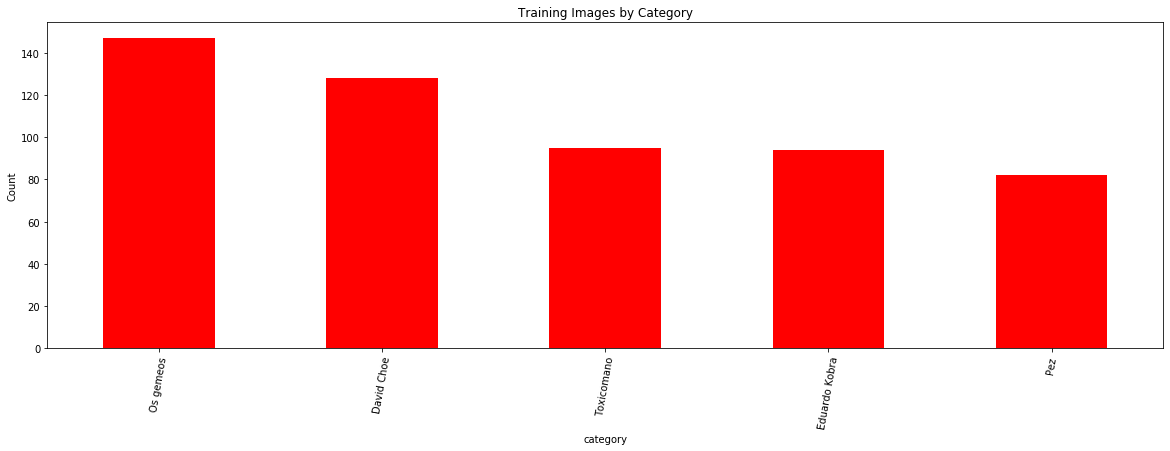

In [4]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

#### forma y composición de las imagenes

las imagenes tienen diferente forma y resolucion.

In [5]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                       \
               count        mean         std    min     25%    50%    75%   
category                                                                    
David Choe     128.0  243.031250  114.374639  133.0  183.00  194.0  259.0   
Eduardo Kobra   94.0  297.414894  189.621548  110.0  176.50  194.0  275.0   
Os gemeos      147.0  297.544218  246.651555  124.0  183.00  194.0  275.0   
Pez             82.0  195.634146   31.122423  132.0  177.25  192.5  213.0   
Toxicomano      95.0  193.726316   26.667153  146.0  178.00  184.0  197.5   

                       width                                                \
                  max  count        mean         std    min     25%    50%   
category                                                                     
David Choe      846.0  128.0  275.945312   88.875593  163.0  225.00  263.5   
Eduardo Kobra   846.0   94.0  367.957447  196.694453  183.0  259.00  286.0   
Os gemeos      1600.0  147.0  332.517007  219.997956  168.0  247.50  275.0   
Pez             276.0   82.0  263.658537   39.698313  183.0  236.25  261.5   
Toxicomano      300.0   95.0  264.326316   31.851197  168.0  255.00  275.0   

                               
                  75%     max  
category                       
David Choe     278.75   640.0  
Eduardo Kobra  448.75   970.0  
Os gemeos      314.50  2100.0  
Pez            283.75   383.0  
Toxicomano     282.00   344.0

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

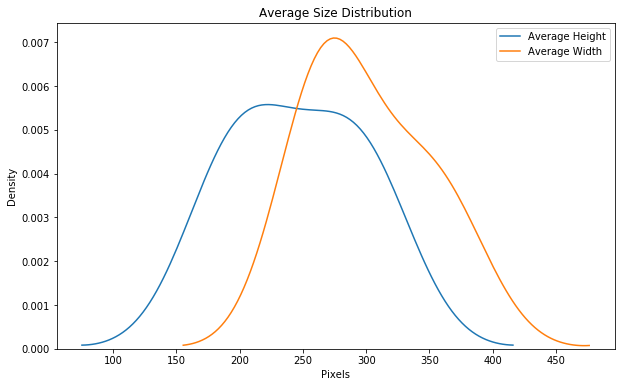

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

# Tamaño de las imagenes
para el procesamiento de las imagenes usando una red pre' entrenada sobre imagenet, las imagenes deben tener un tamaño de 224 x 224.

# Preprocesamiento de las imagenes

1. **Normalización**  restamos la media y dividimos por la desviación estandar por cada canal de color. 

2. **Data Augmentation** esta tecnica nos permite incrementar el número de imágenes sobre la cual la Red Neuronal se va a entrenar,  aleatoriamente  modificamos las imagenes, recortando partes, griando horizontal o vertical, estos cambios se realizan sobre cada Epoch, lo que se traduce en que la red procesará para su entrenamiento diferentes versiones de la misma imagen, este proceso de data augmentatión solo se realiza sobre el train set.



In [7]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Algunos Ejemplos de data Augmentation

imprimimos una imagen

In [8]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

We'll work with two example images and apply the train transformations.

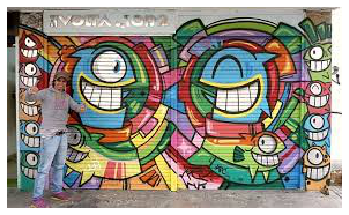

In [9]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


ex_img = Image.open('/Users/Javier/Archivos/MIDS/Semestre III/trabajo de grado/pytorch_challenge-master/pytorch_challenge-master/artgraffv4/test/Pez/001.jpg')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

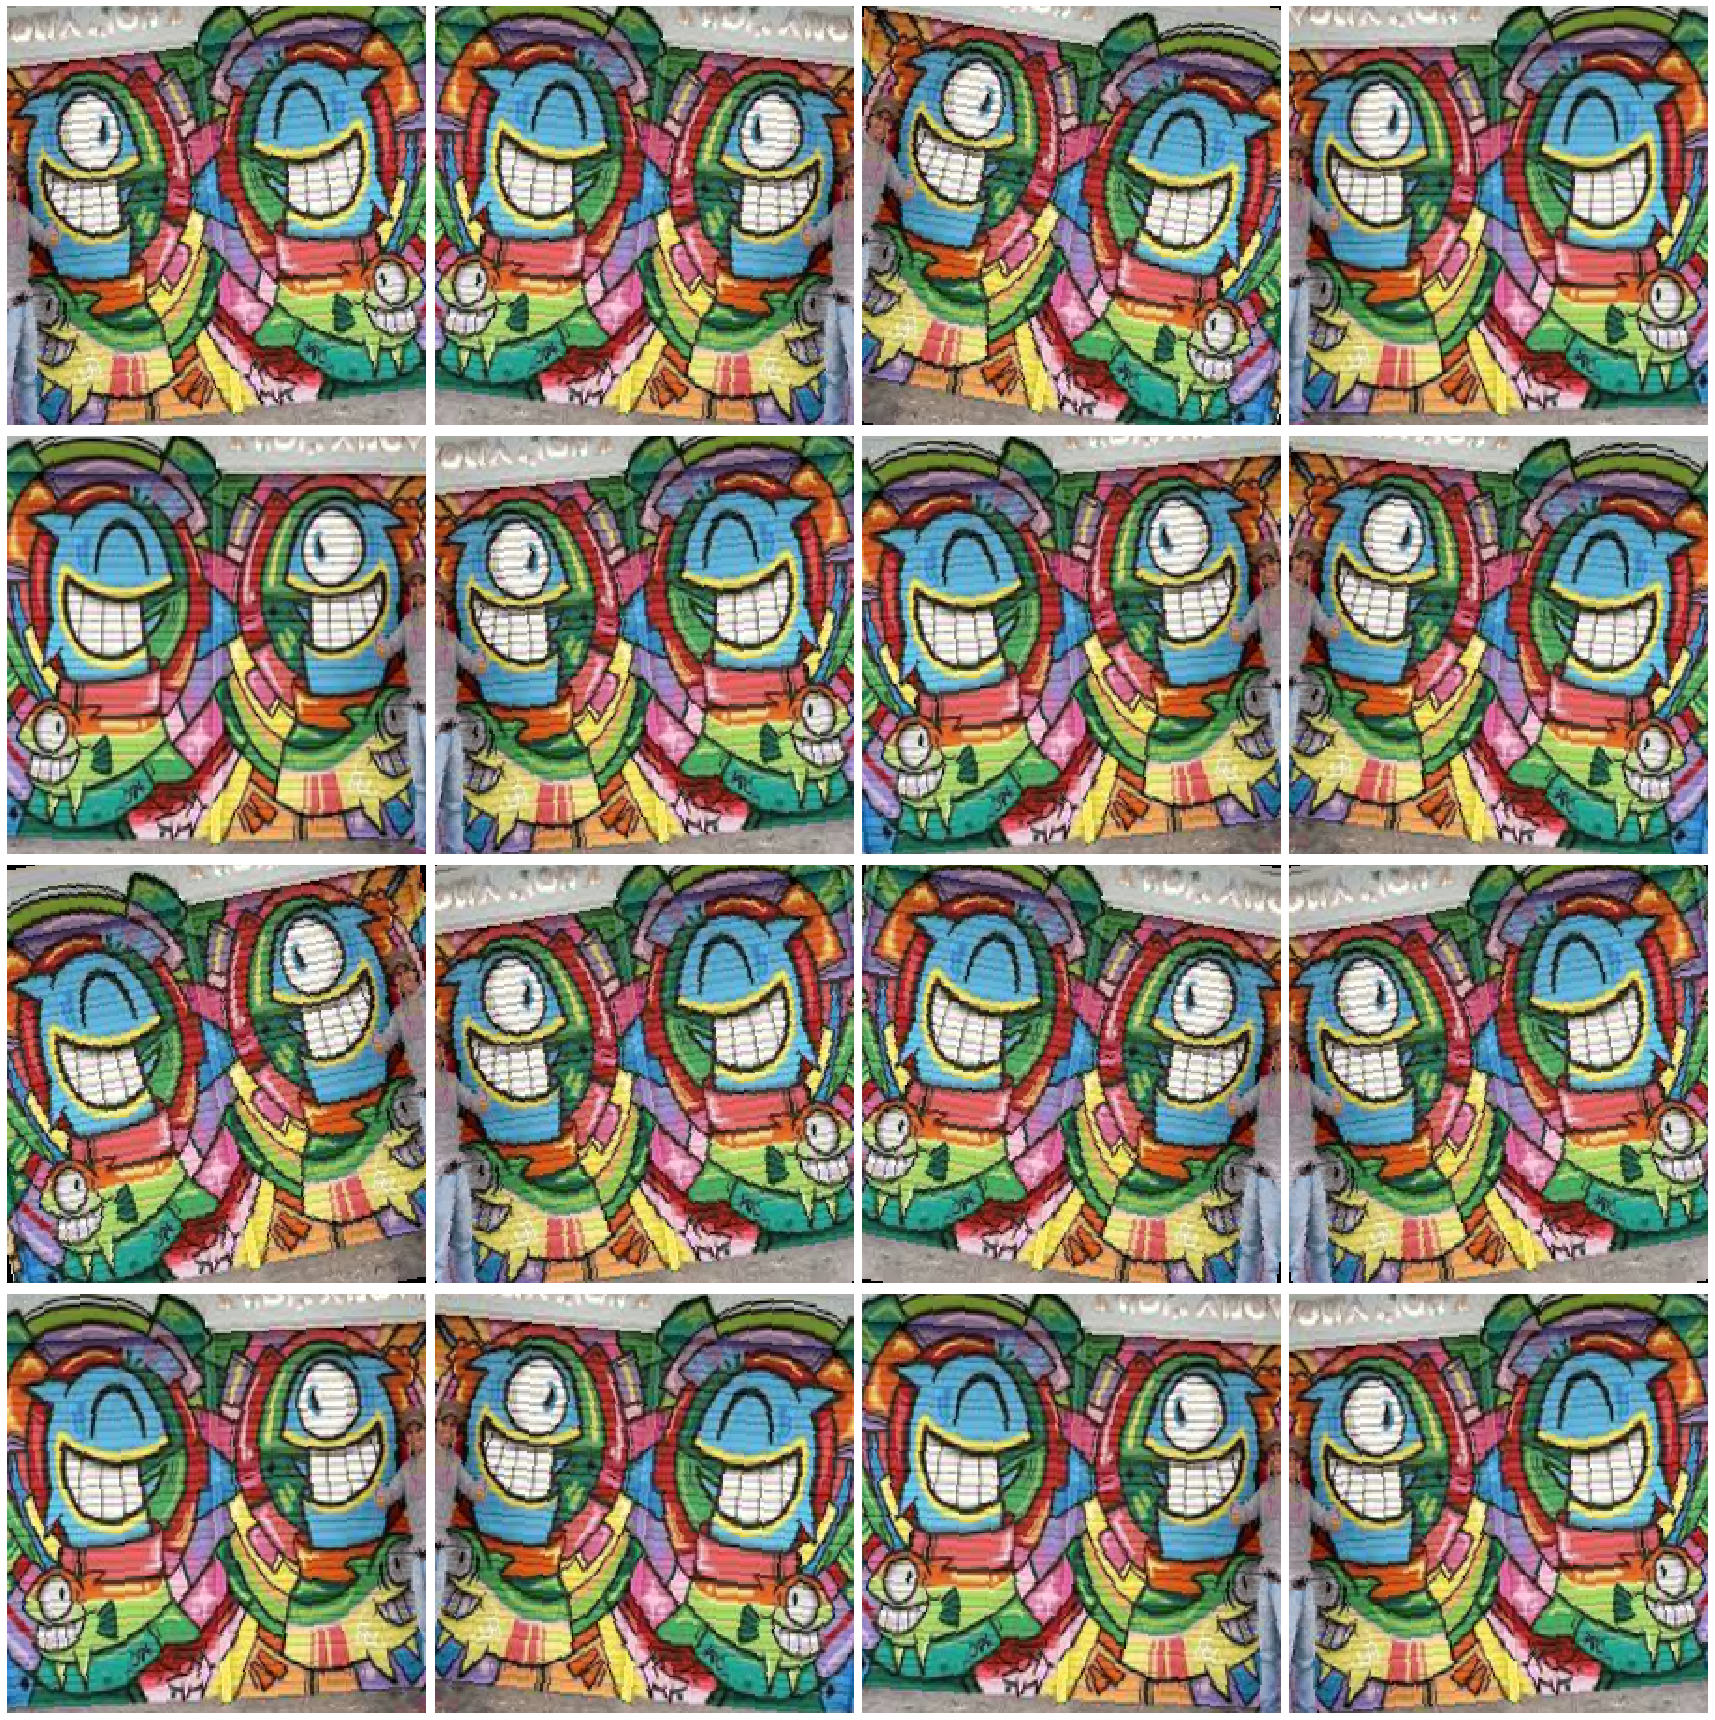

In [10]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

## Data Iterators

Para evitar cargar toda la información a memoria al tiempo, usamos `DataLoaders`. primero creamos un diccionario con las carpetas de las imagenes y lo pasamos al `DataLoader`. En el entrenamiento, el `DataLoader` cargará las imagenes desde disco, realizará las transformaciones, y despliega un Batch. 



In [11]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

La forma (shape) de un batch is `(batch_size, color_channels, height, width)`. 

deberia haber cinco clases lo confirmamos a continuación.

In [13]:
n_classes = len(cat_df)
print(f'hay  {n_classes} clases diferentes.')

len(data['train'].classes)

hay  5 clases diferentes.


5

# Modelos pre entrenados para la clasificación de imagenes


El proceso para usar un modelo pre entrenado de image recognition es el siguiente:

1. Cargar los pesos de la red pre- entrenada
2. Congelar los pesos de las primeras capas de la red
    * Las capas a congelar pueden cambiar con base en la similaridad del la tarea con el dataset original de entrenamiento.
3. Reemplazar el clasificador (utima capa) con un clasificador personalizado a la tarea.
    * El numero de salidas debe conincidir con el numero de clases.
4. Se entrena el Clasificador.

La idea detras del uso de la red preentrenada, es que las redes convolucionales extraen Features que son relevantes para diferentes tareas de reconocimiento de imagenes, la ultima capa se especializa en entender cuales features corresponden a las imagenes.


 

Los modelos que contiene pytorch pre- entrenados son:

In [14]:
model_options = pd.read_csv('models.csv')
model_options

,model,params
0,AlexNet,61100840
1,DenseNet,7978856
2,Inception3,27161264
3,SqueezeNet,1248424
4,alexnet,61100840
5,densenet121,7978856
6,densenet161,28681000
7,densenet169,14149480
8,densenet201,20013928
9,inception_v3,27161264


## Process to Use Pre-Trained Model

iniciamos el proceso usando VGG16



In [15]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Congelar primeras capas.

Congelamos las capas existentes definiendo `requires_grad` to `False`. 



In [16]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False


### Construimos un clasificador personalizado


Cosntruimos un clasificador con las siguientes capas.

* Capa totalmente conectada con ReLU como función de activación (n_inputs, 256)
* Dropout con 40% de probabilidad.
* Capa completamente conectada con salida log Softmax (256, n_classes)

Para constuir nuestro clasificador personalizado usamos el modulo `nn.Sequential()` que es la forma mas basica de pytorch para asignar capas seguidas, asignamos nuestro clasificador al final del clasificador de la red ya entrenada, cuando agregamos las capas adicionales les definimos `require_grad=True` para que puedan ser entrenadas.



In [17]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
    (4): LogSoftmax()
  )
)

The final output will be log probabilities which we can then use in the Negative Log Likelihood Loss. 

La salida final son logaritmo de las probabilidades, que podemos utilizar en la funcion de perdida Negative Log Likelihood Loss.

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,661 total parameters.
1,050,117 training parameters.




Incluso con solo con unas pocas capas definidas como entrenables, hay mas de un millon de peso que seran actualizados durante el entrenamiento.

### entrenando en GPU

movemos el modelo a la GPU y posteriormente cargaremos los datos. 

In [19]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

## Funcion para cargar el modelo pre-entrenado.

funciona solo con VGG16 y Resnet 50.

In [20]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model



La libreria `torchsummary` tiene una fucnion `summary` que nos permite obtener un resumen de nuestro modelo

In [21]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [22]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax()
)



#### Mapear Clases a Indices.

para monitorear los resultados de las predicciones del modelo, creamos un mapeo de clases a indices y de indices a clases, lo que nos permitirá identificar la respectiva clase de una prediccíon.


In [23]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'David Choe'),
 (1, 'Eduardo Kobra'),
 (2, 'Os gemeos'),
 (3, 'Pez'),
 (4, 'Toxicomano')]

# Función de perdida y optimización

La función de perdida es el  negative log likelihood y el optimizador es Adam optimizer. la negative log likelihood en PyTorch recibe los logaritmos de las probabilidades, por lo que debemos pasar la salida del log softmax en nuestro modelo a la última capa. 

* Loss (criterion): lleva el registro de la perdida y de el gradiente de la perdida con respecto al los parámetros (pesos)
* Optimizer: atialoza los parametros (pesos) con los gradientes.
 

In [24]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


Podemos observar los parametros (pesos) que van a ser optimizados durante el entrenamiento.

In [25]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


# Entenamiento

Para el entrenamiento iteramos sobre el `DataLoader`, en la que pasa un batch de informaciòn por el modelo. al final de cada batch, calculamos la perdida con `criterion(output, targets)` y entonces calculamos los gradientes de la perdida sobre los parametros con `loss.backward()`.

Despues de calcular los gradientes, usamos `optimizer.step()` para actualizar los modelos de los parametros con el gradiente. usamos Adam una version del stochastic gradient descent. 


## Early Stopping

Usamos Early stopping como una forma de regularizar el modelo y evitar el overfitting





In [26]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [27]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 8.80 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.7274 	Validation Loss: 0.4948
		Training Accuracy: 75.46%	 Validation Accuracy: 80.56%
Epoch: 3	100.00% complete. 8.53 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5139 	Validation Loss: 0.5532
		Training Accuracy: 82.60%	 Validation Accuracy: 80.56%
Epoch: 5	100.00% complete. 8.50 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.4564 	Validation Loss: 0.5074
		Training Accuracy: 83.15%	 Validation Accuracy: 86.11%
Epoch: 6	100.00% complete. 8.52 seconds elapsed in epoch.
Early Stopping! Total epochs: 6. Best epoch: 1 with loss: 0.49 and acc: 84.72%
72.30 total seconds elapsed. 10.33 seconds per epoch.


# Resultados del entrenamiento

podemos revisar los resultados `history`. 

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

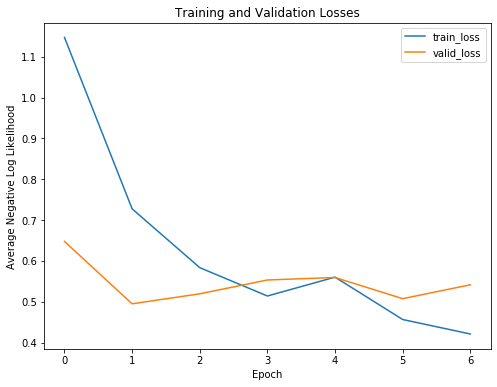

In [28]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')



Como se espera, el error de entrenamiento decrece con cada Epoch, en cierto punto el error de validacion deja de decrecer.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

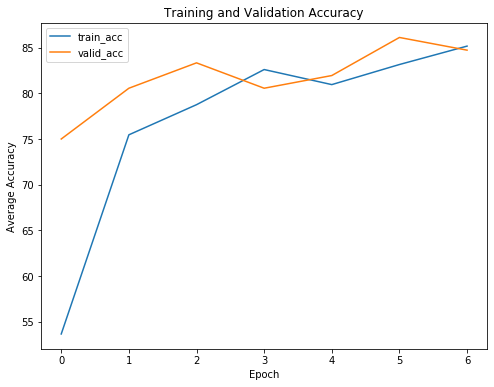

In [29]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

# Guardamos el modelo

La funcion `train` guarda el mejor modelo `state_dict()` que son los pesos del modelo. para guardar mas informacion del modelo usamos la siguiente funcion.

In [30]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [31]:
save_checkpoint(model, path=checkpoint_path)

## cargar el modelo en un checkpoint


In [32]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [33]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

135,310,661 total parameters.
1,050,117 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 2

usamos esas funciones para guardar y cargar el modelo

In [34]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 7 epochs.

Epoch: 1	100.00% complete. 8.55 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.5234 	Validation Loss: 0.5098
		Training Accuracy: 81.14%	 Validation Accuracy: 83.33%
Epoch: 3	100.00% complete. 8.43 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.4398 	Validation Loss: 0.5413
		Training Accuracy: 84.43%	 Validation Accuracy: 81.94%
Epoch: 5	100.00% complete. 8.52 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.4307 	Validation Loss: 0.4586
		Training Accuracy: 84.07%	 Validation Accuracy: 84.72%
Epoch: 7	100.00% complete. 8.51 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.3906 	Validation Loss: 0.5131
		Training Accuracy: 86.45%	 Validation Accuracy: 80.56%
Epoch: 9	100.00% complete. 8.54 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.3473 	Validation Loss: 0.4493
		Training Accuracy: 87.55%	 Validation Accuracy: 84.72%
Epoch: 11	100.00% complete. 8.64 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.3422 	Validati

# Inferencia

Una vez obtenemos un modelo que a pesar de hacer modificaiones no mejoran los resultados podemos proceder a hacer inferencia sobre los datos de test, es decir datos que no fueron usados en el entrenamiento, para validar la capacidad de generalizar del modelo.

Esta funcion toma ñlos datos de la carpeta de validacion y les aplica las trasnformaciones que tienen los datos de entrenamiento.

In [35]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

## función para hacer predicciones.

The next function makes predictions on a single image. It will return the top probabilities and classes. 
Las función hace prediccion sobre una imagen, arroja como resultados la probabilidades y las claseses

In [36]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

This function can be used to pick a random test image. 

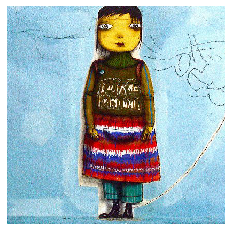

In [37]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [38]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

torch.Size([3, 224, 224])

In [39]:
top_p, top_classes, real_class

(array([7.3678088e-01, 1.9295707e-01, 6.6729471e-02, 3.4140849e-03,
        1.1853398e-04], dtype=float32),
 ['Os gemeos', 'David Choe', 'Pez', 'Toxicomano', 'Eduardo Kobra'],
 'David Choe')

In [40]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([6.3315570e-01, 2.6071587e-01, 1.0245127e-01, 3.3181803e-03,
        3.5895314e-04], dtype=float32),
 ['Os gemeos', 'David Choe', 'Pez', 'Toxicomano', 'Eduardo Kobra'],
 'Pez')

### funcion para desplegar alas predicciones



In [41]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

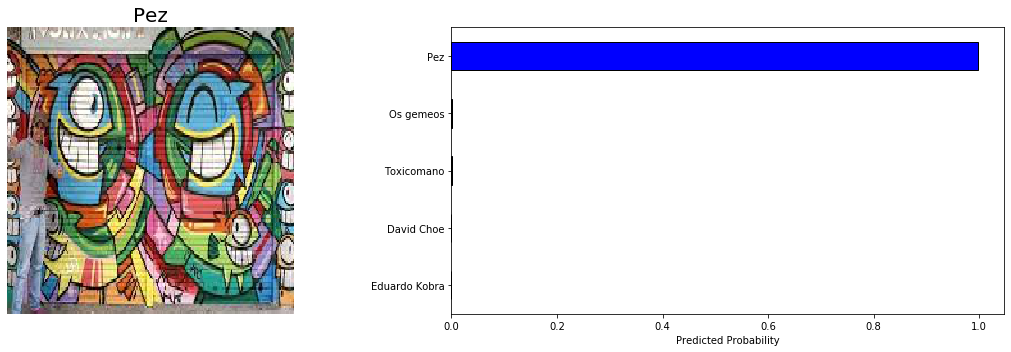

In [42]:
display_prediction(random_test_image(), model, topk=5)

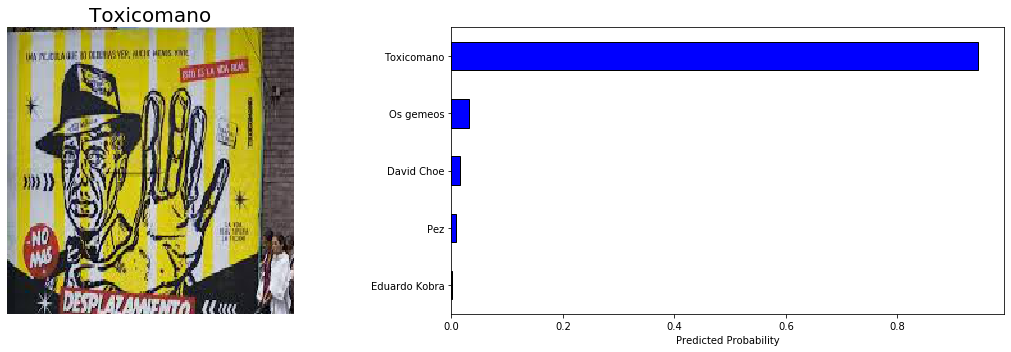

In [43]:
display_prediction(random_test_image(), model, topk=5)

# testeando el accuracy




Esta funcion computa el accuracy de una prediccion y un objetivo.

In [44]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        print(pred)

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [45]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, ))
else:
    accuracy(model(features), targets, topk=(1, 5))

tensor([[0, 2, 3, 0, 4, 0, 3, 2, 2, 4, 1, 2, 3, 1, 1, 3, 1, 0, 3, 3, 4, 3, 3, 4,
         0, 2, 1, 2, 4, 0, 0, 4]], device='cuda:0')


[75.0]

In [46]:
def accuracy2(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        a, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
       
        return a, pred

In [47]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)


if train_on_gpu:
    a, pred =accuracy2(model(features.to('cuda')), targets, topk=(1, 0))
else:
    a, pred = accuracy2(model(features), targets, topk=(1, 0))

In [48]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)


if train_on_gpu:
    a =accuracy2(model(features.to('cuda')), targets, topk=(1, 5))
else:
    a = accuracy2(model(features), targets, topk=(1, 5))

In [49]:
testiter = iter(dataloaders['test'])

yt = []
yp = []

for i in range(3):
    
    # Get a batch of testing images and labels
    features, targets = next(testiter)
    yt.append(targets.numpy())
    
    a, pred =accuracy2(model(features.to('cuda')), targets, topk=(1,))
    yp.append(pred.cpu().numpy())
    
    
yt = np.concatenate(yt)
yp = np.concatenate(yp)
yp =yp.reshape(1,-1)
yp =yp.reshape(-1)

# Calculo de metricas de evaluacion
F1 Score
Matriz de confusion

In [50]:
from sklearn.metrics import f1_score
y_true = yt
y_pred = yp
f1_score(y_true, y_pred, average='macro')

f1_score(y_true, y_pred, average='micro')

f1_score(y_true, y_pred, average='weighted')

f1_score(y_true, y_pred, average=None)

0.8111779448621552

0.8000000000000002

0.7988077336197636

array([0.8       , 0.9       , 0.83333333, 0.78571429, 0.73684211])

In [51]:
def sb_confusion_matrix(y_true, y_pred):
  data = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (5,4))
  sn.set(font_scale=1)#for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

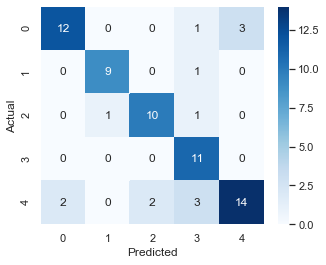

In [52]:
sb_confusion_matrix(yt, yp)